In [1]:
using PyPlot
#plotly()
import StatsBase  

# Generating functions

In [2]:
function logphid(mu,d=1/2)
    return log(sum(mu.^d)^(1/d))
end

function logphid_c(mu,d=1/2)
    e=ones(length(mu))/length(mu)
    return logphid(mu,d)-logphid(e,d)
end

function posphid(mu,d=1/2)
    return mu.^(d)./(exp(d*logphid(mu,d)))
end

function psid(mu1,mu2,d=1/2)
    
    mu1=reshape(mu1,length(mu1),1)
    mu2=reshape(mu2,length(mu2),1)

    ret=mu2./mu1
    pos=posphid(mu1,d)
    
    rbh=log.(pos'*ret)[1,1]
    rrb=logphid(mu2,d)-logphid(mu1,d)
    
    return rbh-rrb,rrb
end


psid (generic function with 2 methods)

In [3]:
function logphie(mu)
    return mean(log.(mu))
end

function logphie_c(mu)
    e=ones(length(mu))/length(mu)
    return logphie(mu)-logphie(e)
end

function posphie(mu)
    e=ones(length(mu))/length(mu)
    return e
end

function psie(mu1,mu2)
    
    mu1=reshape(mu1,length(mu1),1)
    mu2=reshape(mu2,length(mu2),1)

    ret=mu2./mu1
    pos=posphie(mu1)
    
    rbh=log.(pos'*ret)[1,1]
    rrb=logphie(mu2)-logphie(mu1)
    
    return rbh-rrb,rrb
end



psie (generic function with 1 method)

In [4]:
function logphient(mu)
    mu=reshape(mu,length(mu),1)
    return -sum(mu'*log.(mu))
end

function logphient_c(mu)
    e=ones(length(mu))/length(mu)
    return logphient(mu)-logphient(e)
end


function posphient(mu)

    pos=(mu.*log.(mu))/sum(mu.*log.(mu))
    
    return pos
end

function psient(mu1,mu2)
    
    mu1=reshape(mu1,length(mu1),1)
    mu2=reshape(mu2,length(mu2),1)

    ret=mu2./mu1
    pos=posphient(mu1)
    
    rbh=log.(pos'*ret)[1,1]
    rrb=logphient(mu2)-logphient(mu1)
    
    return rbh-rrb,rrb
end


psient (generic function with 1 method)

In [5]:
function generategraphdata(f)
    
    n = 100
    x = linspace(0.001, 0.999, n)
    xgrid=x*ones(n,1)'
    ygrid=xgrid'

    z = Array{Float64}(n, n)

    for i in 1:n
        for j in 1:n
        
        
            vv=[x[i],x[j],1-x[i]-x[j]]
        
            if x[i]+x[j]<1
                z[i, j] = f(vv)
            
            
            else
                z[i, j] = NaN
            end
        
        
        end
    end
    
    return xgrid,ygrid,z 
    
end

generategraphdata (generic function with 1 method)

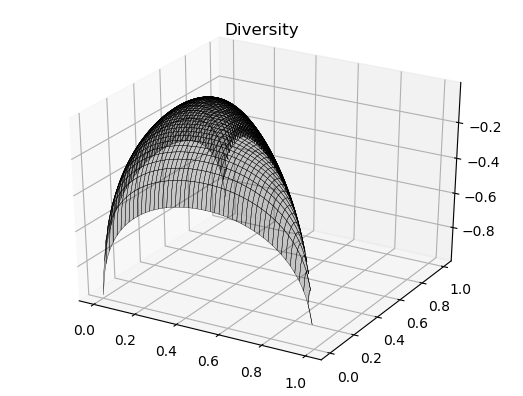

PyObject Text(0.5,0.92,'Diversity')

In [7]:
pygui(false)

xgrid,ygrid,z=generategraphdata(logphid_c)

surf(xgrid, ygrid, z, rstride=2,edgecolors="k", cstride=2,
cmap=ColorMap("gray"), alpha=0.2, linewidth=0.25)
title("Diversity")

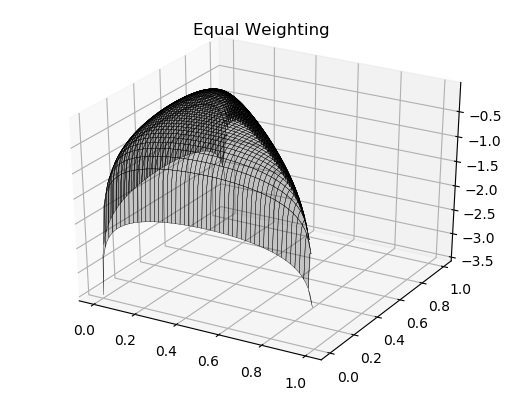

PyObject Text(0.5,0.92,'Equal Weighting')

In [8]:
pygui(false)

xgrid,ygrid,z=generategraphdata(logphie_c)

surf(xgrid, ygrid, z, rstride=2,edgecolors="k", cstride=2,
   cmap=ColorMap("gray"), alpha=0.2, linewidth=0.25)
title("Equal Weighting")


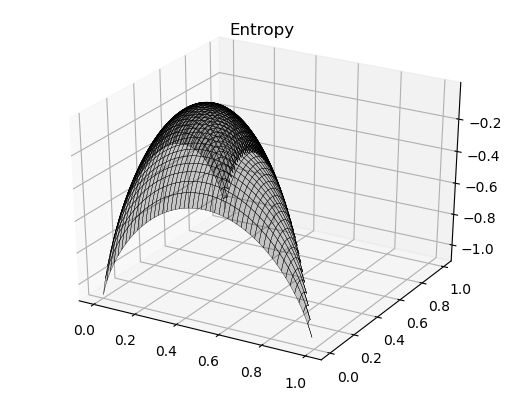

PyObject Text(0.5,0.92,'Entropy')

In [9]:

xgrid,ygrid,z=generategraphdata(logphient_c)

surf(xgrid, ygrid, z, rstride=2,edgecolors="k", cstride=2,
   cmap=ColorMap("gray"), alpha=0.2, linewidth=0.25)
title("Entropy")


# Simulations

In [57]:
function sim(t,nsim,mu,sig)
    
    srand(4972)
    na=length(mu)
    
    shocks=randn(t,na,nsim)
    logrets=Array{Float64, 3}(t,na,nsim)
    res=Array{Float64, 3}(t+1,na,nsim)
    
    
    dd=kron((mu-0.5*sig.^2)',ones(t,1))
    ss=kron(sig',ones(t,1))
    
    for k in 1:nsim
        
        logrets[:,:,k]=ss.*shocks[:,:,k]+dd
        res[:,:,k]=vcat(zeros(1,na),cumsum(ss.*shocks[:,:,k]+dd))
        
        
    end   

    
    return res,logrets
    
end

sim (generic function with 1 method)

In [58]:
function weights(data)
    
    res=Array{Float64, 3}(size(data))
    
    dataexp=exp.(data)
   
    for k in 1:size(data)[3]
        
        res[:,:,k]=dataexp[:,:,k]./(kron(ones(1,size(data)[2]),sum(dataexp[:,:,k],2)))
        
    end   
   
    return res
    
end

weights (generic function with 1 method)

### Stats to be based on following function of log-returns

Local quadratic approximation of $\psi(x)$ at $0$:
$$\frac{1}{2}\left[\sum_{i=1}^{N}\pi_{i}x_{i}^2-\sum_{i,j}\pi_{i}\pi_{j}x_{i}x_{j}\right],$$
$$=\frac{1}{2}\left[\sum_{i=1}^{N}\pi_{i}x_{i}^2-\left(\sum_{i=1}^{N}\pi_{i}x_{i}\right)^{2}\right],$$
$$=\frac{1}{2}\left[\sum_{i=1}^{N}\pi_{i}(x_{i}-\bar{x})^2-\left(\sum_{i=1}^{N}\pi_{i}(x_{i}-\bar{x})\right)^{2}\right],$$
for any constant $\bar{x}$.


In [59]:
function dispstat(ret)
   
    ret=reshape(ret,length(ret),1)
    e=ones(length(ret),1)/length(ret)
    
    
    res=e'*(ret.^2)-(e'*ret)^2
    
    return res[1]
    
end

dispstat (generic function with 1 method)

In [94]:
function statsoflogreturns(data)
    
    datacum=Array{Float64, 3}(size(data))

    resseq=Array{Float64, 2}(size(data)[1],size(data)[3])
    resseqcum=Array{Float64, 2}(size(data)[1],size(data)[3])
    rescum=Array{Float64, 2}(size(data)[1],size(data)[3])


    for k in 1:size(data)[3]
        
        datacum[:,:,k]=cumsum(data[:,:,k])
        
        for i in 1:size(data)[1]

            resseq[i,k]=dispstat(data[i,:,k])
            rescum[i,k]=dispstat(datacum[i,:,k])    
        end
        
        resseqcum[:,k]=cumsum(resseq[:,k])
                
    end
    
    return resseqcum,rescum
    
    
end

statsoflogreturns (generic function with 1 method)

### The following function is for double checking

In [61]:
function returnsfromdata(data)
    
    res=Array{Float64, 3}(size(data)[1]-1,size(data)[2],size(data)[3])
       
    for k in 1:size(data)[3]
        
        res[:,:,k]=data[2:end,:,k]./data[1:(end-1),:,k]
    end   
   
    return res
    
end

returnsfromdata (generic function with 1 method)

## Parameters for the simulation


In [62]:
nsim=100000
T=20
na=50

mu=0.05*ones(na,1)
sig=0.16*ones(na,1);


#print(mu-0.5*sig.^2)




# Starting simulations

In [63]:
res,logrets=sim(T,nsim,mu,sig);
ww=weights(res);
retweights=returnsfromdata(ww);

pygui(true)
fig = figure()

#for k in 1:size(ww)[3]
for k in 50:51
    
    tt=ww[:,:,k]
    rr=1:size(ww)[1]
    plot3D(tt[rr,1],tt[rr,2],tt[rr,3])
end

a11=linspace(0,1,100)
a12=1-a11
a13=0*a11


a22=linspace(0,1,100)
a23=1-a22
a21=0*a22

a33=linspace(0,1,100)
a31=1-a33
a32=0*a33


plot3D(a11,a12,a13,color = "k")
plot3D(a21,a22,a23,color = "k")
plot3D(a31,a32,a33,color = "k")
    
ax = gca()
ax[:set_xlim]([0,1])
ax[:set_ylim]([0,1])
ax[:set_zlim]([0,1])



In [64]:
function return_attrib(ww,f)
 
    gamstar=Array{Float64, 2}(size(ww)[1]-1,size(ww)[3])
    deltaphi=Array{Float64, 2}(size(ww)[1]-1,size(ww)[3])
    retphi=Array{Float64, 2}(size(ww)[1]-1,size(ww)[3])


    for k in 1:size(ww)[3]
        for j in 2:size(ww)[1]

            mu1=ww[j-1,:,k]
            mu2=ww[j,:,k]

            #if k==1 && j==2 print(f(mu1,mu2)) end
            gamstar[j-1,k],deltaphi[j-1,k]=f(mu1,mu2)

            retphi[j-1,k]=gamstar[j-1,k]+deltaphi[j-1,k]
        end
    end

    return retphi,gamstar,deltaphi

end

return_attrib (generic function with 1 method)

In [65]:
retphi_d,gamstar_d,deltaphi_d=return_attrib(ww,psid);
retphi_e,gamstar_e,deltaphi_e=return_attrib(ww,psie);
retphi_ent,gamstar_ent,deltaphi_ent=return_attrib(ww,psient);



In [66]:
function cumulate(retphi,gamstar,deltaphi)

    retphi_cum=Array{Float64, 2}(size(retphi)[1],size(retphi)[2])
    gamstar_cum=Array{Float64, 2}(size(retphi)[1],size(retphi)[2])
    deltaphi_cum=Array{Float64, 2}(size(retphi)[1],size(retphi)[2])

    for k in 1:size(retphi)[2]

        retphi_cum[:,k]=cumsum(retphi[:,k])
        gamstar_cum[:,k]=cumsum(gamstar[:,k])
        deltaphi_cum[:,k]=cumsum(deltaphi[:,k])

    end
    
    return retphi_cum,gamstar_cum,deltaphi_cum

end

cumulate (generic function with 1 method)

In [96]:
retphi_d_cum,gamstar_d_cum,deltaphi_d_cum=cumulate(retphi_d,gamstar_d,deltaphi_d)
retphi_e_cum,gamstar_e_cum,deltaphi_e_cum=cumulate(retphi_e,gamstar_e,deltaphi_e)
retphi_ent_cum,gamstar_ent_cum,deltaphi_ent_cum=cumulate(retphi_ent,gamstar_ent,deltaphi_ent);

disp_stats_seq,disp_stats_cum=statsoflogreturns(logrets)
disp_stats=disp_stats_seq-disp_stats_cum;

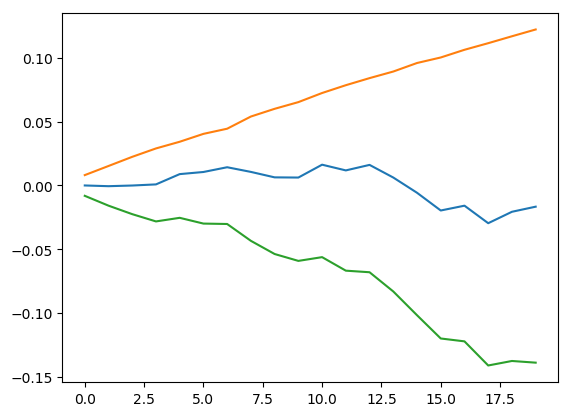

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13eb54390>

In [115]:
pygui(false)

# For one simulation

k=3

fig = figure(k)
plot(retphi_d_cum[:,k])
plot(gamstar_d_cum[:,k])
plot(deltaphi_d_cum[:,k])



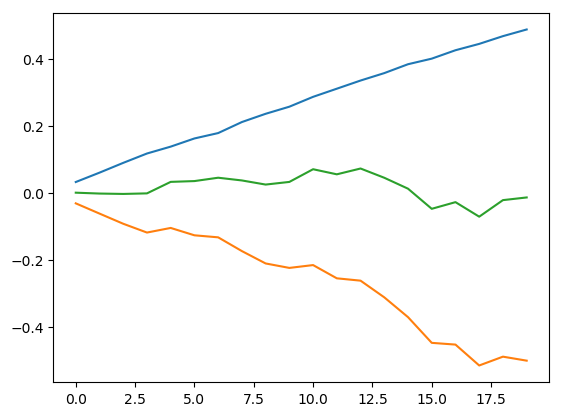

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13ecba750>

In [116]:
# For one simulation

k=3
plot(disp_stats_seq[:,3])
plot(-disp_stats_cum[:,3])
plot(disp_stats_seq[:,3]-disp_stats_cum[:,3])



In [87]:
t=size(retphi_d_cum)[1]
print("-------\n")
print(mean(retphi_d_cum[t,:]/t))
print("\n")
print(std(retphi_d_cum[t,:]/t))
print("\n")
print("-------\n")
print(mean(retphi_e_cum[t,:]/t))
print("\n")
print(std(retphi_e_cum[t,:]/t))
print("\n")
print("-------\n")
print(mean(retphi_ent_cum[t,:]/t))
print("\n")
print(std(retphi_ent_cum[t,:]/t))
print("\n")
print("-------\n")
print(mean(disp_stats[t,:]/t))
print("\n")
print(std(disp_stats[t,:]/t))

-------
6.114030674762643e-5
0.0014270904592117196
-------
8.154311010192256e-5
0.0026398684869135465
-------
3.954298800970802e-5
0.0008459101156353797
-------
1.3142140674048772e-5
0.004925417463081207

In [89]:
print(mean(gamstar_d_cum[t,:]/t))
print("\n-------\n")
print(mean(gamstar_e_cum[t,:]/t))
print("\n-------\n")
print(mean(gamstar_ent_cum[t,:]/t))

0.006259897359515556
-------
0.012538630590805068
-------
0.012323591613984854

In [92]:
print(mean(deltaphi_d_cum[t,:]/t))
print("\n-------\n")
print(mean(deltaphi_e_cum[t,:]/t))
print("\n-------\n")
print(mean(deltaphi_ent_cum[t,:]/t))

-0.006198757052767928
-------
-0.012457087480703146
-------
-0.012284048625975147

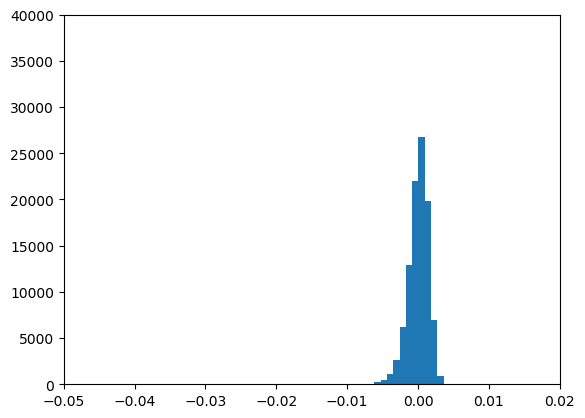

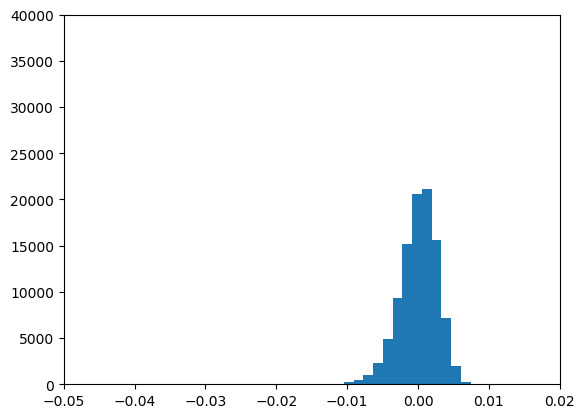

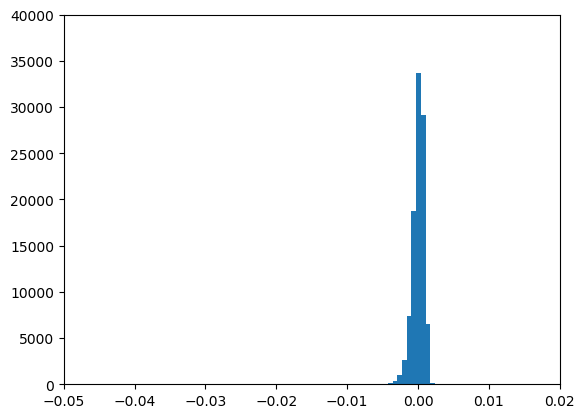

(0, 40000)

In [22]:
pygui(false)
figure(1)
h = PyPlot.plt[:hist](retphi_d_cum[t,:]/t,20);
ax = gca()
ax[:set_xlim]([-0.05,0.02])
ax[:set_ylim]([0,40000])

figure(2)
h = PyPlot.plt[:hist](retphi_e_cum[t,:]/t,20);
ax = gca()
ax[:set_xlim]([-0.05,0.02])
ax[:set_ylim]([0,40000])

figure(3)
h = PyPlot.plt[:hist](retphi_ent_cum[t,:]/t,20);
ax = gca()
ax[:set_xlim]([-0.05,0.02])
ax[:set_ylim]([0,40000])


In [23]:
cdf_d=StatsBase.ecdf(retphi_d_cum[t,:]/t)
cdf_e=StatsBase.ecdf(retphi_e_cum[t,:]/t)
cdf_ent=StatsBase.ecdf(retphi_ent_cum[t,:]/t)

(::ef) (generic function with 2 methods)

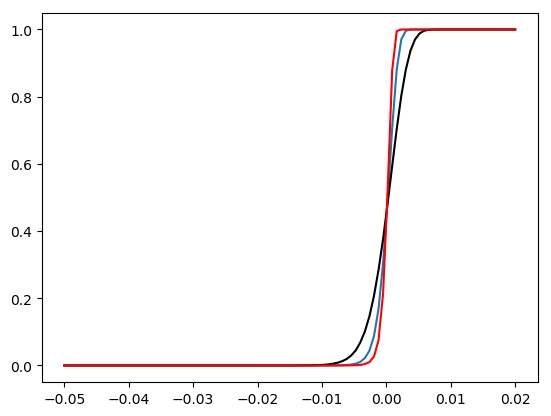

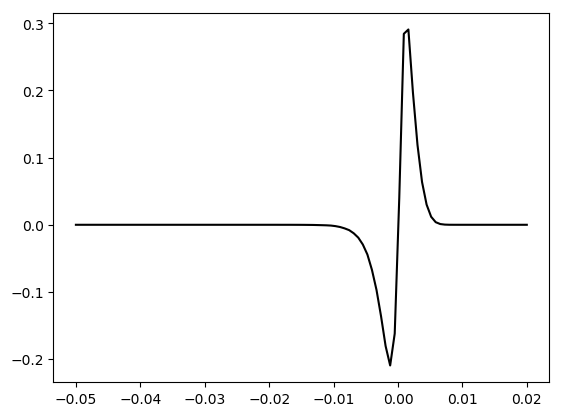

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13c8d0510>

In [24]:
x=linspace(-0.05,0.02,100)

fig=figure(1)
plot(x,cdf_d(x))
plot(x,cdf_e(x),color="k")
plot(x,cdf_ent(x),color="r")
fig=figure(2)
plot(x,cdf_ent(x)-cdf_e(x),color="k")


In [25]:
test=sum(retweights/size(retweights)[2],2)
mean(log.(test))

8.154311010189782e-5

In [37]:
tt1=[2 3]'
tt2=[1 2]'

2×1 Array{Int64,2}:
 1
 2

In [38]:
tt1'*tt2

1×1 Array{Int64,2}:
 8

In [21]:
size(logrets)

(20, 50, 100000)

In [23]:
dispstat(logrets[10,:,1])

0.2708137304373621